# Projekt SSN (Sztuczne sieci neuronowe)
### Autorzy: Aleksander Folfas, Zosia Jaworksa, Maciej Komosa, Kajetan Łodej, Natalia Łyś

### Opis
Lorem ipsum. <- tutaj ma być opis

### Przegląd literatury
Lorem ipsum. <- tutaj przeglad literatury

## Kod sztucznej sieci neuronowej

In [25]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Wczytanie danych

### Kod funkcji aktywacji

In [27]:
# Liniowa funkcja aktywacji
def identity(x, pochodna = False):
    if pochodna:
        return 1 + 0*x
    return x
# Progowa funkcja aktywacji
def binary_step(x, pochodna = False):
    if pochodna:
        return None
    return np.where(x > 0, 1, 0)
# Logistyczna funkcja aktywacji
def sigmoid(x, pochodna = False):
    if pochodna:
        return sigmoid(x)*(1-sigmoid(x))
    return 1/(1+np.exp(-x))
# Hiperboliczna funkcja aktywacji
def tanh(x, pochodna = False):
    if pochodna:
        return 1 - np.tanh(x)**2
    return np.tanh(x)
# Liniowa z nasyceniem funkcja aktywacji
def linear_saturation(x, pochodna = False):
    if pochodna:
        return None
    return np.maximum(-1, np.minimum(1, x))
# Softplus
def softplus(x, pochodna = False):
    if pochodna:
        return sigmoid(x)
    return np.log(1+np.exp(x))
# Rectified Linear Unit - ReLU
def relu(x, pochodna = False):
    if pochodna:
        return None
    return np.maximum(x, 0)
# Exponential Linear Unit - Elu
def elu(x, pochodna = False):
    if pochodna:
        return np.where(x > 0, 1, np.exp(x))
    return np.where(x > 0, x, np.exp(x) - 1)
# Sigmoid linear unit - SiLU
def silu(x, pochodna = False):
    if pochodna:
        return sigmoid(x) + x*sigmoid(x)*(1-sigmoid(x))
    return x*sigmoid(x)
# Gaussian 
def gaussian(x, pochodna = False):
    if pochodna:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

### Wizualizacja funkcji aktywacji

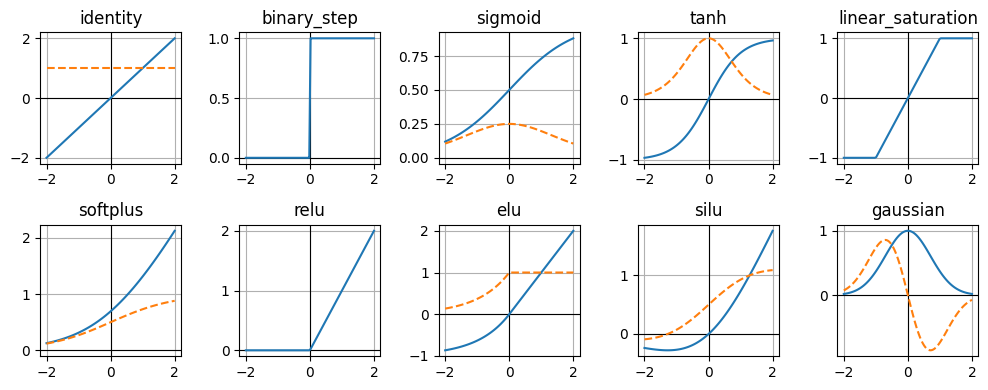

In [28]:
# Ustawienia siatki
rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 4))

# Tworzenie wykresów dla każdej funkcji
functions = [identity, binary_step, sigmoid, tanh, linear_saturation, softplus, relu, elu, silu, gaussian]
function_names = ['identity', 'binary_step', 'sigmoid', 'tanh', 'linear_saturation', 'softplus', 'relu', 'elu', 'silu', 'gaussian']

for i, ax in enumerate(axes.flatten()):
    x = np.linspace(-2, 2, 100)
    y = functions[i](x)
    y_derivatives = functions[i](x, pochodna=True)
    ax.axhline(0, color='black', linewidth=0.8)  
    ax.axvline(0, color='black', linewidth=0.8)
    ax.plot(x, y, linewidth=1.5)
    if y_derivatives is not None:
        ax.plot(x, y_derivatives, linewidth=1.5, linestyle='--')
    ax.set_title(function_names[i])
    ax.grid(True)



plt.tight_layout()

plt.show()
